In [1]:
# import standard python libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, subprocess
# Import python package for working with cooler files and tools for analysis
import cooler
import cooltools

In [2]:
Het_cis_eigs_500kb_files=[f'/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/merged_valid_pairs_cooler_cooltools_output/Het/Het.500000.cis.vecs.tsv', f'/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/merged_valid_pairs_cooler_cooltools_output/Het/Het.500000.cis.lam.txt']
Het_cis_eigs_eigenvectors_500kb=pd.read_csv(Het_cis_eigs_500kb_files[0], sep='\t')
with open(Het_cis_eigs_500kb_files[1], 'r') as eigenvalue_file:
    Het_cis_eigs_eigenvalues = eigenvalue_file.read()
# cis_eigs[0] returns eigenvalues, here we focus on eigenvectors    
Het_cis_eigs_results_500kb = [Het_cis_eigs_eigenvalues,Het_cis_eigs_eigenvectors_500kb]
Het_eigenvector_track_500kb =Het_cis_eigs_results_500kb[1][['chrom','start','end','E1']]

In [3]:
Homo_cis_eigs_500kb_files=[f'/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/merged_valid_pairs_cooler_cooltools_output/Homo/Homo.500000.cis.vecs.tsv', f'/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/merged_valid_pairs_cooler_cooltools_output/Homo/Homo.500000.cis.lam.txt']
Homo_cis_eigs_eigenvectors_500kb=pd.read_csv(Homo_cis_eigs_500kb_files[0], sep='\t')
with open(Homo_cis_eigs_500kb_files[1], 'r') as eigenvalue_file:
    Homo_cis_eigs_eigenvalues = eigenvalue_file.read()
# cis_eigs[0] returns eigenvalues, here we focus on eigenvectors    
Homo_cis_eigs_results_500kb = [Homo_cis_eigs_eigenvalues,Homo_cis_eigs_eigenvectors_500kb]
Homo_eigenvector_track_500kb =Homo_cis_eigs_results_500kb[1][['chrom','start','end','E1']]


In [4]:
merged = pd.merge(
    Het_eigenvector_track_500kb,
    Homo_eigenvector_track_500kb,
    on=["chrom", "start", "end"],
    suffixes=("_Het", "_Homo")
)


In [7]:
merged = merged.dropna(subset=["E1_Het", "E1_Homo"])
merged["E1_diff"] = merged["E1_Het"] - merged["E1_Homo"]
merged["E1_abs_diff"] = (merged["E1_Het"] - merged["E1_Homo"]).abs()

In [8]:
print(merged)


     chrom     start       end    E1_Het   E1_Homo   E1_diff  E1_abs_diff
6     chr1   3000000   3500000  0.056527 -0.471172  0.527699     0.527699
7     chr1   3500000   4000000 -0.050538 -0.540329  0.489791     0.489791
8     chr1   4000000   4500000 -0.349234 -0.659753  0.310519     0.310519
9     chr1   4500000   5000000 -0.005015 -0.121851  0.116836     0.116836
10    chr1   5000000   5500000  0.061125 -0.220570  0.281695     0.281695
...    ...       ...       ...       ...       ...       ...          ...
5455  chrY  88500000  89000000 -0.064961 -0.340451  0.275490     0.275490
5456  chrY  89000000  89500000 -0.666369  0.023509 -0.689879     0.689879
5457  chrY  89500000  90000000 -0.099399  0.110972 -0.210371     0.210371
5458  chrY  90000000  90500000 -0.002296  0.097106 -0.099402     0.099402
5459  chrY  90500000  91000000 -0.649832 -0.237673 -0.412159     0.412159

[5008 rows x 7 columns]


In [10]:
threshold = merged["E1_abs_diff"].quantile(0.95)
large_diff = merged[merged["E1_abs_diff"] >= threshold]
print(large_diff)

     chrom     start       end    E1_Het   E1_Homo   E1_diff  E1_abs_diff
6     chr1   3000000   3500000  0.056527 -0.471172  0.527699     0.527699
7     chr1   3500000   4000000 -0.050538 -0.540329  0.489791     0.489791
45    chr1  22500000  23000000  0.262288 -0.125174  0.387462     0.387462
189   chr1  94500000  95000000 -1.044884 -0.443537 -0.601347     0.601347
190   chr1  95000000  95500000 -0.589921 -0.182867 -0.407054     0.407054
...    ...       ...       ...       ...       ...       ...          ...
5452  chrY  87000000  87500000 -0.209715  0.179584 -0.389299     0.389299
5453  chrY  87500000  88000000  3.112969  1.163715  1.949254     1.949254
5454  chrY  88000000  88500000  0.356465 -0.184622  0.541087     0.541087
5456  chrY  89000000  89500000 -0.666369  0.023509 -0.689879     0.689879
5459  chrY  90500000  91000000 -0.649832 -0.237673 -0.412159     0.412159

[251 rows x 7 columns]


In [11]:
def check_overlap(df1, df2):
    overlaps = []
    for _, row in df1.iterrows():
        overlap = df2[
            (df2["chrom"] == row["chrom"]) &
            (df2["start"] <= row["end"]) &
            (df2["end"] >= row["start"])
        ]
        if not overlap.empty:
            overlaps.append(True)
        else:
            overlaps.append(False)
    return overlaps


In [14]:
cluster_bed_file ="/lustre/home/acct-medlqian/medlqian-loop3/database/olfactory_receptor_information/OR_cluster_information.bed"
cluster_bed = pd.read_csv(cluster_bed_file, sep="\t", header=None,
                  names=["chrom", "start", "end", "name"], index_col=False)

large_diff = merged[merged["E1_abs_diff"] >= threshold].copy()
large_diff["in_cluster_bed"] = check_overlap(large_diff, cluster_bed)


In [16]:
# 总数
total = len(large_diff)

# 落在 cluster_bed 中的数量
in_cluster = large_diff["in_cluster_bed"].sum()

# 计算比例
ratio = in_cluster / total

print(f"总共差异大的 bin 数量: {total}")
print(f"落在 cluster_bed 区域中的数量: {in_cluster}")
print(f"占比: {ratio:.2%}")

总共差异大的 bin 数量: 251
落在 cluster_bed 区域中的数量: 8
占比: 3.19%


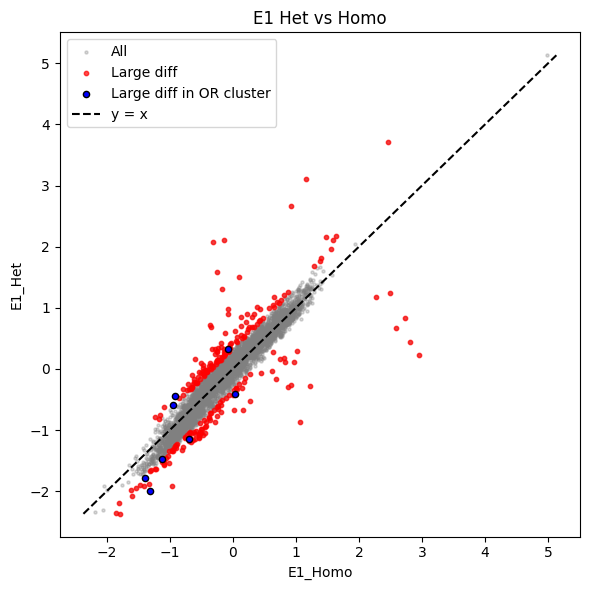

In [23]:
import matplotlib.pyplot as plt

# 先筛出三类点
all_points = merged
large_diff_points = large_diff
large_diff_in_cluster = large_diff[large_diff["in_cluster_bed"] == True]

plt.figure(figsize=(6, 6))

# 所有点（灰）
plt.scatter(all_points["E1_Homo"], all_points["E1_Het"],
            s=5, alpha=0.3, color='gray', label='All')

# 差异大的点（红）
plt.scatter(large_diff_points["E1_Homo"], large_diff_points["E1_Het"],
            s=10, alpha=0.7, color='red', label='Large diff')

# 落在 OR cluster 中的点（蓝）
plt.scatter(large_diff_in_cluster["E1_Homo"], large_diff_in_cluster["E1_Het"],
            s=20, alpha=1, color='blue', edgecolor='black', label='Large diff in OR cluster')

# 对角线 y = x
lims = [min(merged["E1_Homo"].min(), merged["E1_Het"].min()),
        max(merged["E1_Homo"].max(), merged["E1_Het"].max())]
plt.plot(lims, lims, 'k--', label='y = x')

# 图形细节
plt.xlabel("E1_Homo")
plt.ylabel("E1_Het")
plt.title("E1 Het vs Homo")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()


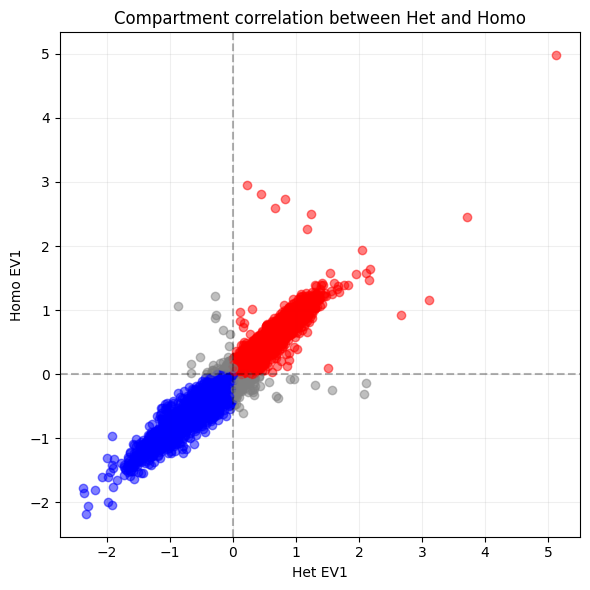

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

for i, row in merged.iterrows():
    x = row["E1_Het"]
    y = row["E1_Homo"]
    if x > 0 and y > 0:
        color = 'red'
    elif x < 0 and y < 0:
        color = 'blue'
    else:
        color = 'grey'
    plt.plot(x, y, 'o', color=color, alpha=0.5)

plt.axhline(0, color='k', linestyle='--', alpha=0.3)
plt.axvline(0, color='k', linestyle='--', alpha=0.3)

plt.xlabel("Het EV1")
plt.ylabel("Homo EV1")
plt.title("Compartment correlation between Het and Homo")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


In [18]:
def classify_compartment(row):
    x, y = row["E1_Het"], row["E1_Homo"]
    if x > 0 and y > 0:
        return "AA"
    elif x < 0 and y < 0:
        return "BB"
    elif x > 0 and y < 0:
        return "AB"
    elif x < 0 and y > 0:
        return "BA"
    else:
        return "other"

merged["compartment_pair"] = merged.apply(classify_compartment, axis=1)


In [19]:
compartment_counts = merged["compartment_pair"].value_counts()
compartment_proportions = merged["compartment_pair"].value_counts(normalize=True)


In [20]:
print("计数：")
print(compartment_counts)

print("\n比例：")
print(compartment_proportions)


计数：
compartment_pair
BB    2485
AA    2155
AB     272
BA      96
Name: count, dtype: int64

比例：
compartment_pair
BB    0.496206
AA    0.430312
AB    0.054313
BA    0.019169
Name: proportion, dtype: float64
